In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

from sklearn.pipeline import make_pipeline
! pip install category_encoders -q
from category_encoders import TargetEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from warnings import filterwarnings
filterwarnings('ignore', category=DeprecationWarning) 
filterwarnings('ignore', category=FutureWarning) 

     |████████████████████████████████| 72 kB 778 kB/s 


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/AML Project/Data/train.csv', dtype={'weather': 'category'})
df_test = pd.read_csv('/content/drive/MyDrive/AML Project/Data/test.csv', dtype={'weather': 'category'})

dev_X = df_train.drop(columns=['casual', 'registered', 'count'])
dev_y = np.log(df_train['count'])
dev_X.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0


## Utils

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view


def df2samples(look_back, dev_X, dev_y, test_X):
  df_dev, df_test = dev_X.copy(), test_X.copy()
  df_dev['y'], df_test['y'] = dev_y, -1
  df_all = pd.concat([df_dev, df_test]).sort_values(by=[dev_X.shape[1] - 1]).drop(columns=[dev_X.shape[1] - 1])
  
  samples = sliding_window_view(df_all.to_numpy(), (look_back, df_all.shape[1])).squeeze().astype(float)
  dev_samples = samples[samples[:, -1, -1] != -1]
  dev_y = dev_samples[:, -1, -1]
  dev_X = dev_samples[:, :, :-1]
  test_X = samples[samples[:, -1, -1] == -1][:, :, :-1]
  return dev_X, dev_y[:, None], test_X

def parse_dt(df, task='regression'):

  df_trans = df.copy()
  dt_col = pd.to_datetime(df['datetime'], infer_datetime_format=True).dt
  df_trans['year'] = pd.Categorical(dt_col.year)
  df_trans['month'] = pd.Categorical(dt_col.month)
  df_trans['dayofweek'] = pd.Categorical(dt_col.weekday)
  df_trans['hour'] = pd.Categorical(dt_col.hour)
  
  f_to_drop = ['datetime', 'temp', 'season', 'workingday']
  df_trans = df_trans.drop(columns=f_to_drop)
  if task == 'timeseries': df_trans['datetime'] = pd.to_datetime(df['datetime'], infer_datetime_format=True)
  
  return df_trans

## Regression

In [ ]:
dev_X_reg = dev_X.drop(columns=['datetime'])

In [ ]:
dev_X_reg_trans = parse_dt(dev_X)
dev_X_reg_trans.head()

,holiday,weather,atemp,humidity,windspeed,year,month,dayofweek,hour
0,0,1,14.395,81,0.0,2011,1,5,0
1,0,1,13.635,80,0.0,2011,1,5,1
2,0,1,13.635,80,0.0,2011,1,5,2
3,0,1,14.395,75,0.0,2011,1,5,3
4,0,1,14.395,75,0.0,2011,1,5,4


In [ ]:
# preprocess

num_features = ['atemp', 'humidity', 'windspeed']
ord_features = ['year']
ohe_features = ['weather']
te_features = ['month', 'dayofweek', 'hour']
preprocess = make_column_transformer((OrdinalEncoder(), ord_features), 
                    (OneHotEncoder(), ohe_features), 
                    (TargetEncoder(), te_features), remainder='passthrough')

### ElasticNet

In [ ]:
# ElasticNet
en_par = {
    'alpha': np.logspace(-5, 0, 10), 
    'l1_ratio': np.logspace(-5, 0, 10)
    }

en_pipe = make_pipeline(StandardScaler(), GridSearchCV(ElasticNet(random_state=42), param_grid=en_par, n_jobs=-1)).fit(dev_X_reg, dev_y)
en_fe_pipe = make_pipeline(preprocess, StandardScaler(), GridSearchCV(ElasticNet(random_state=42), param_grid=en_par, n_jobs=-1)).fit(dev_X_reg_trans, dev_y)

print('Without features engineering, ElasticNet gets {} with {}'.format(en_pipe.named_steps['gridsearchcv'].best_score_ , en_pipe.named_steps['gridsearchcv'].best_params_))
print('After features engineering, ElasticNet gets {} with {}'.format(en_fe_pipe.named_steps['gridsearchcv'].best_score_ , en_fe_pipe.named_steps['gridsearchcv'].best_params_))

Without features engineering, ElasticNet gets 0.13782819346688274 with {'alpha': 0.07742636826811278, 'l1_ratio': 1e-05}
After features engineering, ElasticNet gets 0.8003025172453061 with {'alpha': 1e-05, 'l1_ratio': 1e-05}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.096e+03, tolerance: 2.413e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [ ]:
en_scores = en_pipe.named_steps['gridsearchcv'].cv_results_['mean_test_score'].reshape((10, 10))
en_fe_scores = en_fe_pipe.named_steps['gridsearchcv'].cv_results_['mean_test_score'].reshape((10, 10))

### KNN

In [ ]:
# KNN

knn_par = {
    'n_neighbors': np.arange(2, 100, 10),
    'p': np.arange(1, 4)
    }

knn_pipe = make_pipeline(StandardScaler(), GridSearchCV(KNeighborsRegressor(), param_grid=knn_par, n_jobs=-1)).fit(dev_X_reg, dev_y)
knn_fe_pipe = make_pipeline(preprocess, StandardScaler(), GridSearchCV(KNeighborsRegressor(), param_grid=knn_par, n_jobs=-1)).fit(dev_X_reg_trans, dev_y)

print('Without features engineering, KNN gets {} with {}'.format(knn_pipe.named_steps['gridsearchcv'].best_score_, knn_pipe.named_steps['gridsearchcv'].best_params_))
print('After features engineering, KNN gets {} with {}'.format(knn_fe_pipe.named_steps['gridsearchcv'].best_score_, knn_fe_pipe.named_steps['gridsearchcv'].best_params_))

Without features engineering, KNN gets 0.15626861201766415 with {'n_neighbors': 72, 'p': 1}
After features engineering, KNN gets 0.7258016634690703 with {'n_neighbors': 12, 'p': 1}


In [ ]:
knn_scores = knn_pipe.named_steps['gridsearchcv'].cv_results_['mean_test_score'].reshape((10, 3)).T
knn_fe_scores = knn_fe_pipe.named_steps['gridsearchcv'].cv_results_['mean_test_score'].reshape((10, 3)).T


### SVM

In [ ]:
# Linear SVM
svm_par = {
    'epsilon': np.logspace(-3, 0, 10),
    # 'kernel': ['linear', 'poly'],
    # 'gamma': np.logspace(-3, 1, 20), 
    'C': np.logspace(-3, 0, 10)
    }

svm_pipe = make_pipeline(StandardScaler(), GridSearchCV(LinearSVR(random_state=42), param_grid=svm_par, n_jobs=-1)).fit(dev_X_reg, dev_y)
svm_fe_pipe = make_pipeline(preprocess, StandardScaler(), GridSearchCV(LinearSVR(random_state=42), param_grid=svm_par, n_jobs=-1)).fit(dev_X_reg_trans, dev_y)

# svm_pipe = make_pipeline(StandardScaler(), GridSearchCV(SVR(), param_grid=svm_par, n_jobs=-1)).fit(dev_X_reg, dev_y)
# svm_fe_pipe = make_pipeline(preprocess, StandardScaler(), GridSearchCV(SVR(), param_grid=svm_par, n_jobs=-1)).fit(dev_X_reg_trans, dev_y)

print('Without features engineering, SVM gets {} with {}'.format(svm_pipe.named_steps['gridsearchcv'].best_score_ , svm_pipe.named_steps['gridsearchcv'].best_params_))
print('After features engineering, SVM gets {} with {}'.format(svm_fe_pipe.named_steps['gridsearchcv'].best_score_ , svm_fe_pipe.named_steps['gridsearchcv'].best_params_))

Without features engineering, SVM gets 0.1421418971954293 with {'C': 0.004641588833612777, 'epsilon': 0.46415888336127775}
After features engineering, SVM gets 0.8015769045042177 with {'C': 0.01, 'epsilon': 0.46415888336127775}


In [ ]:
svm_scores = svm_pipe.named_steps['gridsearchcv'].cv_results_['mean_test_score'].reshape((10, 10))
svm_fe_scores = svm_fe_pipe.named_steps['gridsearchcv'].cv_results_['mean_test_score'].reshape((10, 10))

### Decision Tree

In [ ]:
# DT

dt_par = {
    'max_depth': np.arange(5, 13),
    'ccp_alpha': np.logspace(-5, -2, 8)
    }

dt_pipe = make_pipeline(StandardScaler(), GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid=dt_par, n_jobs=-1)).fit(dev_X_reg, dev_y)
dt_fe_pipe = make_pipeline(preprocess, StandardScaler(), GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid=dt_par, n_jobs=-1)).fit(dev_X_reg_trans, dev_y)

print('Without features engineering, Decision Tree gets {} with {}'.format(dt_pipe.named_steps['gridsearchcv'].best_score_, dt_pipe.named_steps['gridsearchcv'].best_params_))
print('After features engineering, Decision Tree gets {} with {}'.format(dt_fe_pipe.named_steps['gridsearchcv'].best_score_, dt_fe_pipe.named_steps['gridsearchcv'].best_params_))

Without features engineering, Decision Tree gets 0.1283485653623996 with {'ccp_alpha': 0.003727593720314938, 'max_depth': 10}
After features engineering, Decision Tree gets 0.760438551369919 with {'ccp_alpha': 0.0005179474679231213, 'max_depth': 12}


In [ ]:
dt_scores = dt_pipe.named_steps['gridsearchcv'].cv_results_['mean_test_score'].reshape((8, 8))
dt_fe_scores = dt_fe_pipe.named_steps['gridsearchcv'].cv_results_['mean_test_score'].reshape((8, 8))

### Random Forest

In [ ]:
# RF
rf_par = {
    'n_estimators': np.arange(100, 300, 25), 
    'max_features': np.linspace(0.2, 1, 8)
    }

rf_pipe = make_pipeline(StandardScaler(), GridSearchCV(RandomForestRegressor(random_state=42), param_grid=rf_par, n_jobs=-1)).fit(dev_X_reg, dev_y)
rf_fe_pipe = make_pipeline(preprocess, StandardScaler(), GridSearchCV(RandomForestRegressor(random_state=42), param_grid=rf_par, n_jobs=-1)).fit(dev_X_reg_trans, dev_y)

print('Without features engineering, Random Forest gets {} with {}'.format(rf_pipe.named_steps['gridsearchcv'].best_score_, rf_pipe.named_steps['gridsearchcv'].best_params_))
print('After features engineering, Random Forest gets {} with {}'.format(rf_fe_pipe.named_steps['gridsearchcv'].best_score_, rf_fe_pipe.named_steps['gridsearchcv'].best_params_))

Without features engineering, Random Forest gets 0.0800576847141468 with {'max_features': 0.3142857142857143, 'n_estimators': 175}
After features engineering, Random Forest gets 0.8468108694288523 with {'max_features': 0.8857142857142857, 'n_estimators': 175}


In [ ]:
rf_scores = rf_pipe.named_steps['gridsearchcv'].cv_results_['mean_test_score'].reshape((8, 8))
rf_fe_scores = rf_fe_pipe.named_steps['gridsearchcv'].cv_results_['mean_test_score'].reshape((8, 8))

### Gradient Boosting Tree

In [ ]:
# GBT
gb_par = {
    'n_estimators': np.arange(100, 500, 50), 
    'learning_rate': np.logspace(-3, 0, 8)
    }

gb_pipe = make_pipeline(StandardScaler(), GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid=gb_par, return_train_score=True, n_jobs=-1)).fit(dev_X_reg, dev_y)
gb_fe_pipe = make_pipeline(preprocess, StandardScaler(), GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid=gb_par, return_train_score=True, n_jobs=-1)).fit(dev_X_reg_trans, dev_y)

print('Without features engineering, Random Forest gets {} with {}'.format(gb_pipe.named_steps['gridsearchcv'].best_score_, gb_pipe.named_steps['gridsearchcv'].best_params_))
print('After features engineering, Random Forest gets {} with {}'.format(gb_fe_pipe.named_steps['gridsearchcv'].best_score_, gb_fe_pipe.named_steps['gridsearchcv'].best_params_))

In [ ]:
gb_scores = gb_pipe.named_steps['gridsearchcv'].cv_results_['mean_test_score'].reshape((8, 8))
gb_fe_scores = gb_fe_pipe.named_steps['gridsearchcv'].cv_results_['mean_test_score'].reshape((8, 8))

### Histogram Gradient Boosting Tree

In [ ]:
# HGBT
hgb_par = {
    'max_bins': np.linspace(15, 255, 8, dtype=int),
    'learning_rate': np.logspace(-3, 0, 8)
    }

hgb_pipe = make_pipeline(StandardScaler(), GridSearchCV(HistGradientBoostingRegressor(random_state=42), param_grid=hgb_par, return_train_score=True, n_jobs=-1)).fit(dev_X_reg, dev_y)
hgb_fe_pipe = make_pipeline(preprocess, StandardScaler(), GridSearchCV(HistGradientBoostingRegressor(random_state=42), param_grid=hgb_par, return_train_score=True, n_jobs=-1)).fit(dev_X_reg_trans, dev_y)

print('Without features engineering, hgb gets {} with {}'.format(hgb_pipe.named_steps['gridsearchcv'].best_score_, hgb_pipe.named_steps['gridsearchcv'].best_params_))
print('After features engineering, hgb gets {} with {}'.format(hgb_fe_pipe.named_steps['gridsearchcv'].best_score_, hgb_fe_pipe.named_steps['gridsearchcv'].best_params_))

Without features engineering, Random Forest gets 0.17110555465418967 with {'learning_rate': 0.0517947467923121, 'max_bins': 15}
After features engineering, Random Forest gets 0.88679158781143 with {'learning_rate': 0.13894954943731375, 'max_bins': 117}


In [ ]:
hgb_scores = hgb_pipe.named_steps['gridsearchcv'].cv_results_['mean_test_score'].reshape((8, 8))
hgb_fe_scores = hgb_fe_pipe.named_steps['gridsearchcv'].cv_results_['mean_test_score'].reshape((8, 8))

### Visualization

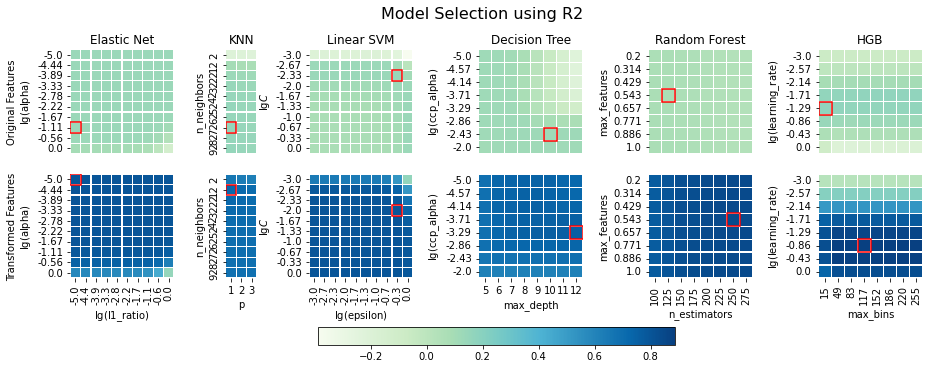

In [ ]:
# Non-tree-based Models

vmin = min(np.min([en_scores, svm_scores]), np.min(knn_scores), np.min([dt_scores, rf_scores, hgb_scores]))
vmax = max(np.max([en_fe_scores, svm_fe_scores]), np.max(knn_fe_scores), np.max([dt_fe_scores, rf_fe_scores, hgb_fe_scores]))
fig, axes = plt.subplots(2, 6, figsize=(16, 6), sharex='col', gridspec_kw=dict(width_ratios=[1, .3, 1, 1, 1, 1]))


# EN
sns.heatmap(en_scores, cmap='GnBu', vmin=vmin, vmax=vmax, cbar=False, square=True, linewidth=.2, 
            xticklabels=np.round(np.log10(en_par['l1_ratio']), 1), yticklabels=np.round(np.log10(en_par['alpha']), 2), ax=axes[0, 0])
axes[0, 0].set(ylabel='Original Features\n$\lg$(alpha)', title='Elastic Net')
axes[0, 0].xaxis.set_ticks_position('none') 
axes[0, 0].add_patch(Rectangle(np.unravel_index(en_scores.T.argmax(), en_scores.T.shape), 1, 1, edgecolor='red', fill=False, lw=1.5))

sns.heatmap(en_fe_scores, cmap='GnBu', vmin=vmin, vmax=vmax, cbar=False, square=True, linewidth=.2,
            xticklabels=np.round(np.log10(en_par['l1_ratio']), 1), yticklabels=np.round(np.log10(en_par['alpha']), 2), ax=axes[1, 0])
axes[1, 0].set(xlabel=r'$\lg$(l1_ratio)', ylabel='Transformed Features\n$\lg$(alpha)')
axes[1, 0].add_patch(Rectangle(np.unravel_index(en_fe_scores.T.argmax(), en_fe_scores.T.shape), 1, 1, edgecolor='red', fill=False, lw=1.5))


# KNN
sns.heatmap(knn_scores.T, cmap='GnBu', vmin=vmin, vmax=vmax, cbar=False, square=True, linewidth=.2, yticklabels=knn_par['n_neighbors'], ax=axes[0, 1])
axes[0, 1].set(ylabel='n_neighbors', title='KNN')
axes[0, 1].xaxis.set_ticks_position('none')
axes[0, 1].add_patch(Rectangle(np.unravel_index(knn_scores.argmax(), knn_scores.shape), 1, 1, edgecolor='red', fill=False, lw=1.5))

sns.heatmap(knn_fe_scores.T, cmap='GnBu', vmin=vmin, vmax=vmax, cbar=False, square=True, linewidth=.2,
            xticklabels=knn_par['p'], yticklabels=knn_par['n_neighbors'], ax=axes[1, 1])
axes[1, 1].set(xlabel='p', ylabel='n_neighbors')
axes[1, 1].add_patch(Rectangle(np.unravel_index(knn_fe_scores.argmax(), knn_fe_scores.shape), 1, 1, edgecolor='red', fill=False, lw=1.5))


# SVM
sns.heatmap(svm_scores, cmap='GnBu', vmin=vmin, vmax=vmax, cbar=False, square=True, linewidth=.2, 
            xticklabels=np.round(np.log10(svm_par['epsilon']), 1), yticklabels=np.round(np.log10(svm_par['C']), 2), ax=axes[0, 2])
axes[0, 2].set(ylabel='$\lg C$', title='Linear SVM')
axes[0, 2].xaxis.set_ticks_position('none') 
axes[0, 2].add_patch(Rectangle(np.unravel_index(svm_scores.T.argmax(), svm_scores.T.shape), 1, 1, edgecolor='red', fill=False, lw=1.5))

sns.heatmap(svm_fe_scores, cmap='GnBu', vmin=vmin, vmax=vmax, cbar=False, square=True, linewidth=.2,
            xticklabels=np.round(np.log10(svm_par['epsilon']), 1), yticklabels=np.round(np.log10(svm_par['C']), 2), ax=axes[1, 2])
axes[1, 2].set(xlabel=r'$\lg$(epsilon)', ylabel='$\lg C$')
axes[1, 2].add_patch(Rectangle(np.unravel_index(svm_fe_scores.T.argmax(), svm_fe_scores.T.shape), 1, 1, edgecolor='red', fill=False, lw=1.5))


# dt
sns.heatmap(dt_scores, cmap='GnBu', vmin=vmin, vmax=vmax, cbar=False, square=True, linewidth=.2, 
            xticklabels=dt_par['max_depth'], yticklabels=np.round(np.log10(dt_par['ccp_alpha']), 2), ax=axes[0, 3])
axes[0, 3].set(ylabel='$\lg$(ccp_alpha)', title='Decision Tree')
axes[0, 3].xaxis.set_ticks_position('none') 
axes[0, 3].add_patch(Rectangle(np.unravel_index(dt_scores.T.argmax(), dt_scores.T.shape), 1, 1, edgecolor='red', fill=False, lw=1.5))

sns.heatmap(dt_fe_scores, cmap='GnBu', vmin=vmin, vmax=vmax, cbar=False, square=True, linewidth=.2,
            xticklabels=dt_par['max_depth'], yticklabels=np.round(np.log10(dt_par['ccp_alpha']), 2), ax=axes[1, 3])
axes[1, 3].set(xlabel='max_depth', ylabel='$\lg$(ccp_alpha)')
axes[1, 3].add_patch(Rectangle(np.unravel_index(dt_fe_scores.T.argmax(), dt_fe_scores.T.shape), 1, 1, edgecolor='red', fill=False, lw=1.5))


# rf
sns.heatmap(rf_scores.T, cmap='GnBu', vmin=vmin, vmax=vmax, cbar=False, square=True, linewidth=.2, 
            xticklabels=rf_par['n_estimators'], yticklabels=np.round(rf_par['max_features'], 3), ax=axes[0, 4])
axes[0, 4].set(ylabel='max_features', title='Random Forest')
axes[0, 4].xaxis.set_ticks_position('none') 
axes[0, 4].add_patch(Rectangle(np.unravel_index(rf_scores.argmax(), rf_scores.shape), 1, 1, edgecolor='red', fill=False, lw=1.5))

sns.heatmap(rf_fe_scores.T, cmap='GnBu', vmin=vmin, vmax=vmax, cbar=False, square=True, linewidth=.2,
            xticklabels=rf_par['n_estimators'], yticklabels=np.round(rf_par['max_features'], 3), ax=axes[1, 4])
axes[1, 4].set(xlabel='n_estimators', ylabel='max_features')
axes[1, 4].add_patch(Rectangle(np.unravel_index(rf_fe_scores.argmax(), rf_fe_scores.shape), 1, 1, edgecolor='red', fill=False, lw=1.5))


# hgb
sns.heatmap(hgb_scores, cmap='GnBu', vmin=vmin, vmax=vmax, cbar=False, square=True, linewidth=.2, 
            xticklabels=hgb_par['max_bins'], yticklabels=np.round(np.log10(hgb_par['learning_rate']), 2), ax=axes[0, 5])
axes[0, 5].set(ylabel=r'$\lg$(learning_rate)', title='HGB')
axes[0, 5].xaxis.set_ticks_position('none') 
axes[0, 5].add_patch(Rectangle(np.unravel_index(hgb_scores.T.argmax(), hgb_scores.T.shape), 1, 1, edgecolor='red', fill=False, lw=1.5))

sns.heatmap(hgb_fe_scores, cmap='GnBu', vmin=vmin, vmax=vmax, cbar=False, square=True, linewidth=.2,
            xticklabels=hgb_par['max_bins'], yticklabels=np.round(np.log10(hgb_par['learning_rate']), 2), ax=axes[1, 5])
axes[1, 5].set(xlabel='max_bins', ylabel=r'$\lg$(learning_rate)')
axes[1, 5].add_patch(Rectangle(np.unravel_index(hgb_fe_scores.T.argmax(), hgb_fe_scores.T.shape), 1, 1, edgecolor='red', fill=False, lw=1.5))


fig.colorbar(plt.gca().get_children()[0], ax=axes.ravel().tolist(), location='bottom', shrink=0.4)
fig.suptitle('Model Selection using R2', fontsize=16)
plt.show()

In [ ]:
# improve HGBT


num_features = ['atemp', 'humidity', 'windspeed']
ord_features = ['year']
ohe_features = ['weather', 'month', 'dayofweek']
te_features = ['hour']
preprocess = make_column_transformer(
                    (StandardScaler(), num_features),
                    (OrdinalEncoder(), ord_features), 
                    (OneHotEncoder(), ohe_features), 
                    (TargetEncoder(), te_features), remainder='passthrough')
hgb_par = {
    'max_bins': np.arange(15, 256, 10),
    'learning_rate': np.logspace(-3, 0, 25)
    }


hgb_fe_pipe = make_pipeline(preprocess, GridSearchCV(HistGradientBoostingRegressor(random_state=42), param_grid=hgb_par, return_train_score=True, n_jobs=-1)).fit(dev_X_reg_trans, dev_y)


print('After features engineering, hgb gets {} with {}'.format(hgb_fe_pipe.named_steps['gridsearchcv'].best_score_, hgb_fe_pipe.named_steps['gridsearchcv'].best_params_))

After features engineering, hgb gets 0.881055990297949 with {'learning_rate': 0.31622776601683794, 'max_bins': 35}


## Time Series

In [ ]:
dev_X_ts = parse_dt(dev_X, task='timeseries')
test_X_ts = parse_dt(df_test, task='timeseries')
dev_X_ts.head()

,holiday,weather,atemp,humidity,windspeed,year,month,dayofweek,hour,datetime
0,0,1,14.395,81,0.0,2011,1,5,0,2011-01-01 00:00:00
1,0,1,13.635,80,0.0,2011,1,5,1,2011-01-01 01:00:00
2,0,1,13.635,80,0.0,2011,1,5,2,2011-01-01 02:00:00
3,0,1,14.395,75,0.0,2011,1,5,3,2011-01-01 03:00:00
4,0,1,14.395,75,0.0,2011,1,5,4,2011-01-01 04:00:00


In [ ]:
# preprocess

ord_features = ['year']
ohe_features = ['weather', 'month', 'dayofweek']
te_features = ['hour']
num_features = ['atemp', 'humidity', 'windspeed']
preprocess = make_column_transformer(
                    (OrdinalEncoder(), ord_features), 
                    (OneHotEncoder(), ohe_features), 
                    (TargetEncoder(), te_features), 
                    (StandardScaler(), num_features), 
                    remainder='passthrough')

dev_X_ts_trans = pd.DataFrame(preprocess.fit_transform(dev_X_ts, dev_y))
test_X_ts_trans = pd.DataFrame(preprocess.transform(test_X_ts))

### LSTM

In [ ]:
from keras.models import load_model, Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, Callback
import tensorflow as tf
from datetime import datetime
!pip install tensorflow-addons -q
from tensorflow_addons.metrics import RSquare

class LSTM_m2o(object):

    def __init__(self, units=20, look_back=4, n_features=12, n_targets=1):

        # model hyperparameters
        self.units = units
        self.look_back = look_back
        self.n_features = n_features
        self.n_targets = n_targets
        self.dropout = 0.25

        # Get directories name
        self.log_dir = 'log'
        self.checkpoint_dir = 'checkpoint'


    def build(self):
        model = Sequential()
        model.add(LSTM(self.units, input_shape=(self.look_back, self.n_features)))
        # model.add(LSTM(self.units, input_shape=(self.look_back, self.n_features), return_sequences=True))
        
        # model.add(LSTM(128))
        model.add(Dropout(self.dropout))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.n_targets))
        
        return model

    def restore(self, filepath):

        # Load the architecture
        self.best_model = load_model(filepath)
        self.best_model.compile(optimizer='Adadelta', loss=['mse'], metrics=[RSquare()])


    def train(self, X_train, y_train, epochs=200, batch_size=64, verbose=1):

        self.model = self.build()
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=['mse'], metrics=[RSquare()])

        # Stop training if error does not improve within 25 iterations
        early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

        # Save the best model ... with minimal error
        filepath = self.checkpoint_dir + '/LSTM.best' + datetime.now().strftime('%d%m%Y_%H:%M:%S') + '.hdf5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=verbose, save_best_only=True, mode='min')

        callback_history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                             validation_split=0.2, verbose=verbose,
                             callbacks=[early_stopping_monitor, checkpoint]).history
        return callback_history

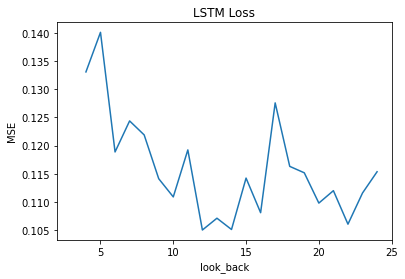

optimal look_back: 12


In [ ]:
# LSTM model selection

lstm_loss, pred = []
look_backs = list(range(4, 25))
for look_back in look_backs:
  dev_X_ts_samp, dev_y_ts_samp, test_X_ts_samp = df2samples(look_back, dev_X_ts_trans, dev_y, test_X_ts_trans)
  lstm = LSTM_m2o(300, look_back, dev_X_ts_samp.shape[-1])
  lstm_loss.append(min(lstm.train(dev_X_ts_samp, dev_y_ts_samp, batch_size=256, verbose=0)['val_loss']))
  pred.append(lstm.model.predict(test_X_ts_samp))

plt.plot(look_backs, lstm_loss)
plt.xlabel('look_back')
plt.xlim(2, 25)
plt.ylabel('MSE')
plt.title('LSTM Loss')
plt.show()

print('optimal look_back:', look_backs[np.argmin(lstm_loss)])

In [ ]:
# output predition
output = pd.DataFrame()
output['datetime'] = df_test['datetime']
output['count'] = np.exp(pred[np.argmin(lstm_loss)])
output.to_csv('output.csv', index=False)